# Load Data

In [5]:
dt = 1/60 # fps
delay = 0.083 # s
T = 50  # frames selected for STA

In [6]:
import datajoint as dj
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import pickle
import stimgenerate as sg
import matplotlib.patches as mpatches
import pandas as pd
import scipy.stats as stats
dj.conn()
# symphony = dj.VirtualModule(module_name='symphony', schema_name='sln_symphony')
# NM = symphony.Experiment.ProtNaturalMovingObjectV2ep() * symphony.Experiment.ProtNaturalMovingObjectV2bp() * symphony.SpikeTrain() &'file_name="101124B"'&'cur_motion_type="natural"'
# CM = symphony.Experiment.ProtNaturalMovingObjectV2ep() * symphony.Experiment.ProtNaturalMovingObjectV2bp() * symphony.SpikeTrain() &'file_name="101124B"'&'cur_motion_type="control"'
# spike_indices_n = NM.fetch('spike_indices')
# spike_indices_c = CM.fetch('spike_indices')
# spike_indices_n = spike_indices_n.tolist()
# spike_indices_c = spike_indices_c.tolist()
# for i in range(len(spike_indices_n)):
#     spike_indices_n[i] = np.transpose(spike_indices_n[i])
# for i in range(len(spike_indices_c)):
#     spike_indices_c[i] = np.transpose(spike_indices_c[i])
    
res_file = r"results/120924B_results.mat"
f = h5py.File(res_file)
f[f[f['results']['NaturalMovingObject'][0][0]]["cx"][0][0]][0]
for cell in f['results']['NaturalMovingObject'][:]:
    if len(f[cell[0]]) < 63:
        continue

    trajx_n = []    
    trajy_n = []    
    trajx_c = []    
    trajy_c = []
    motion_seed_n = []
    motion_seed_c = []    
    spike_indices_n = []
    spike_indices_c = []
    epoch_id_n = []
    epoch_id_c = []
    for cx,cy,si,t,s,en in zip(f[cell[0]]['cx'][0][:], f[cell[0]]['cy'][0][:],f[cell[0]]['spike_indices'][0][:], f[cell[0]]['cur_motion_type'][0][:], f[cell[0]]['motion_seed'][0][:], f[cell[0]]['epoch_id'][0][:]):
        if f[s][:][0] <201 or f[s][:][0] > 300:
            continue

        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'natural':
            trajx_n.extend(f[cx][:])
            trajy_n.extend(f[cy][:])
            motion_seed_n.extend(f[s][:])
            spike_indices_n.append(f[si][:])
            epoch_id_n.append(f[en][:])
        else:
            trajx_c.extend(f[cx][:])
            trajy_c.extend(f[cy][:])
            motion_seed_c.extend(f[s][:])
            spike_indices_c.append(f[si][:])
            epoch_id_c.append(f[en][:])
    break # only use the first cell, for this example

[2025-07-23 14:29:07,810][INFO]: Connecting Jiaming@vfsmdatajoint01.fsm.northwestern.edu:3306
[2025-07-23 14:29:08,237][INFO]: Connected Jiaming@vfsmdatajoint01.fsm.northwestern.edu:3306


In [7]:
with open('results/spike_indices_nV2.pkl', 'wb') as f:
    pickle.dump(spike_indices_n, f)
with open('results/spike_indices_cV2.pkl', 'wb') as f:
    pickle.dump(spike_indices_c, f)
    

In [8]:
trajx_n = np.asarray(trajx_n)
trajy_n = np.asarray(trajy_n)
trajx_c = np.asarray(trajx_c)
trajy_c = np.asarray(trajy_c)

# Spike Raster

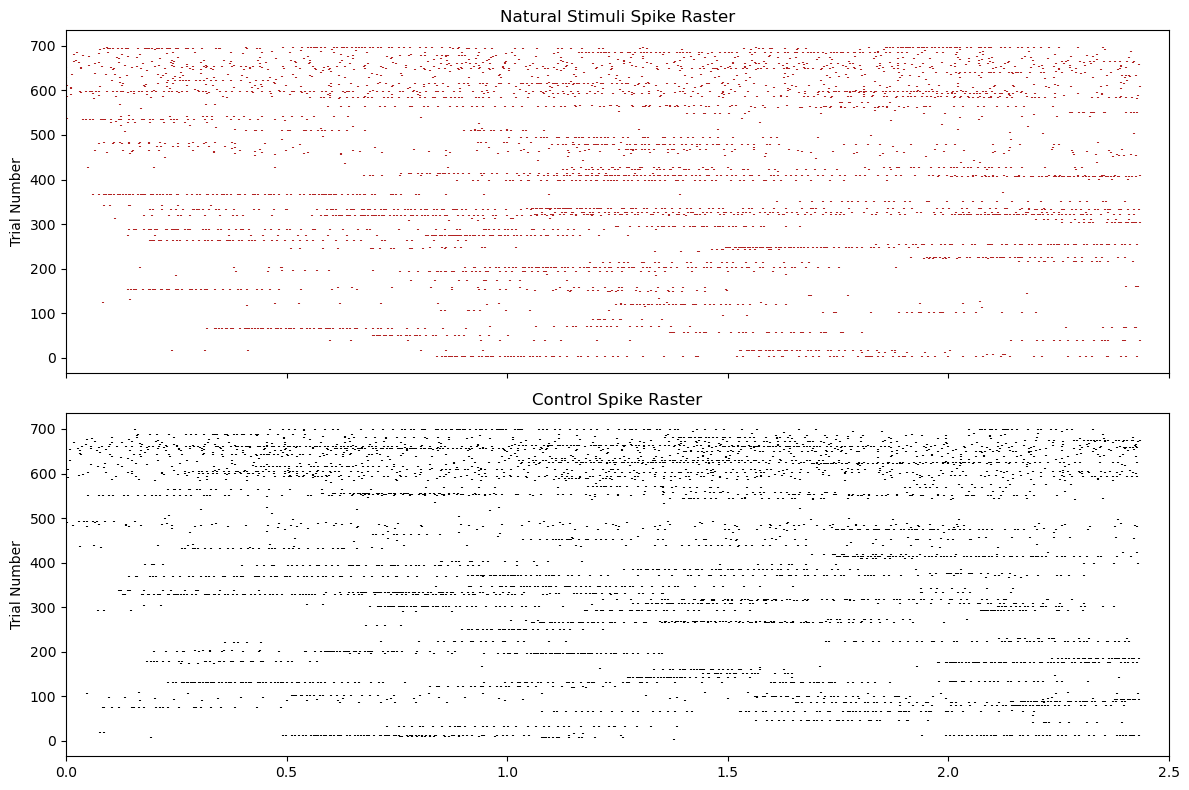

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

num_trials_n = len(spike_indices_n)
spikes_n = []
for spike_idx_n in range(num_trials_n):
    spikes_in_trial = spike_indices_n[spike_idx_n] / 10000 - delay
    spikes_n.extend(spikes_in_trial)
    ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'firebrick', linewidth=1.5)


spikes_c = []
num_trials_c = len(spike_indices_c)
for spike_idx_c in range(num_trials_c):
    spikes_in_trial = spike_indices_c[spike_idx_c] / 10000 - delay
    spikes_c.extend(spikes_in_trial)
    ax2.vlines(spikes_in_trial, spike_idx_c, spike_idx_c + 1, 'k', linewidth=1.5)




ax1.set_ylabel('Trial Number')
ax1.set_title('Natural Stimuli Spike Raster')
ax1.set_xlim(0, 2.5)  


ax2.set_ylabel('Trial Number')
ax2.set_title('Control Spike Raster')
ax2.set_xlim(0, 2.5)  



plt.tight_layout()
plt.show()

# STA

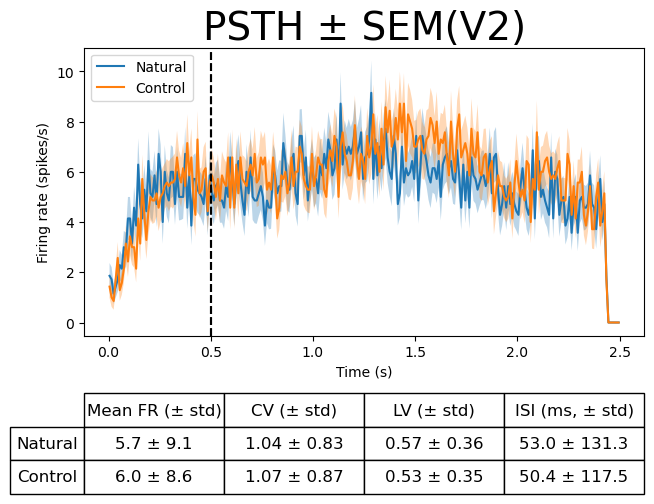

In [10]:

def compute_isis(spike_times):
    """
    Given a 1‑D array of spike times (in seconds) for one trial,
    return the inter‑spike intervals.
    """
    spike_times = np.asarray(spike_times).flatten()
    if len(spike_times) < 2:
        return np.array([])  # no ISI if fewer than 2 spikes
    return np.diff(spike_times)

def compute_cv(isis):
    """Coefficient of variation of ISIs."""
    isis = np.asarray(isis).flatten()
    if isis.size < 2 or np.mean(isis) == 0:
        return np.nan
    return np.std(isis) / np.mean(isis)

def compute_lv(isis):
    """Local Variation (Shinomoto et al. 2003)."""
    isis = np.asarray(isis).flatten()
    if isis.size < 2:
        return np.nan
    return np.mean( 3 * (isis[:-1] - isis[1:])**2 / ( (isis[:-1] + isis[1:])**2 ) )

def compute_spike_counts(spike_indices_list):
    """Number of spikes in each trial."""
    return np.array([ len(np.asarray(idx).flatten()) for idx in spike_indices_list ])

def compute_psth(spike_indices_list, delay=0, bin_size=0.01, t_start=0, t_end=1.5, fs=10000):

    bins = np.arange(t_start, t_end + bin_size, bin_size)
    n_trials = len(spike_indices_list)
    # Compute binned spike counts for each trial
    binned_counts = []
    for inds in spike_indices_list:
        spikes_sec = np.asarray(inds).flatten() / fs - delay
        counts, _ = np.histogram(spikes_sec, bins=bins)
        binned_counts.append(counts)
    binned_counts = np.array(binned_counts)  # shape: (n_trials, n_bins)
    # Normalize to spikes/sec for each trial
    psth_per_trial = binned_counts / bin_size
    # Mean and SEM across trials
    mean_psth = np.nanmean(psth_per_trial, axis=0)
    sem_psth = np.nanstd(psth_per_trial, axis=0) / np.sqrt(n_trials)
    centers = bins[:-1] + bin_size/2
    return centers, mean_psth, sem_psth

# ——— Example: process each condition ———

conditions = {
    "Natural":    spike_indices_n,
    "Control":    spike_indices_c,

}

results = {}

for name, spikes_lst in conditions.items():
    # 1) Spike counts
    counts = compute_spike_counts(spikes_lst)
    
    # 2) ISIs, CVs, LVs per trial
    isis_list = []
    cvs, lvs = [], []
    for idx in spikes_lst:
        t = np.asarray(idx).flatten() / 10000 - delay
        isi = compute_isis(t)
        isis_list.append(isi)
        cvs .append( compute_cv(isi) )
        lvs .append( compute_lv(isi) )
    
    cvs = np.array(cvs)
    lvs = np.array(lvs)
    
    # 3) PSTH with error bars
    bin_centers, mean_psth, sem_psth = compute_psth(spikes_lst,
                                                    delay=delay,
                                                    bin_size=0.01,  # 10 ms bins
                                                    t_start=0,
                                                    t_end=2.5,
                                                    fs=10000)
    
    results[name] = {
        "spike_counts": counts,
        "isis":         isis_list,
        "CV":           cvs,
        "LV":           lvs,
        "psth_t":       bin_centers,
        "psth_rate":    mean_psth,
        "psth_sem":     sem_psth
    }

# ——— Plot PSTHs with error bars ———


# Prepare summary statistics for table
summary_data = []
for name, res in results.items():
    mean_spikes = res['spike_counts'].mean()
    std_spikes = res['spike_counts'].std()
    mean_cv = np.nanmean(res['CV'])
    std_cv = np.nanstd(res['CV'])
    mean_lv = np.nanmean(res['LV'])
    std_lv = np.nanstd(res['LV'])
    # ISI summary: mean and std of all ISIs pooled across all trials
    all_isis = np.concatenate([isi for isi in res['isis'] if len(isi) > 0])
    if all_isis.size > 0:
        mean_isi = np.mean(all_isis)
        std_isi = np.std(all_isis)
        isi_str = f"{mean_isi*1000:.1f} ± {std_isi*1000:.1f}"  # ms
    else:
        isi_str = "n/a"
    summary_data.append([
        f"{mean_spikes/2.5:.1f} ± {std_spikes/2.5:.1f}",
        f"{mean_cv:.2f} ± {std_cv:.2f}",
        f"{mean_lv:.2f} ± {std_lv:.2f}",
        isi_str
    ])

summary_df = pd.DataFrame(
    summary_data,
    index=list(results.keys()),
    columns=["Mean FR (± std)", "CV (± std)", "LV (± std)", "ISI (ms, ± std)"]
)

# Plot PSTH with error bars and add table
fig, ax = plt.subplots(figsize=(8, 6))
for name, res in results.items():
    t = res["psth_t"]
    mean_rate = res["psth_rate"]
    sem_rate = res["psth_sem"]
    ax.plot(t, mean_rate, label=name)
    ax.fill_between(t, mean_rate - sem_rate, mean_rate + sem_rate, alpha=0.3)
    ax.axvline(0.5, color='black', linestyle='--')
ax.set_title('PSTH ± SEM(V2)', fontsize=28)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Firing rate (spikes/s)")
ax.legend()

# Add table below the plot
table = plt.table(
    cellText=summary_df.values,
    rowLabels=summary_df.index,
    colLabels=summary_df.columns,
    cellLoc='center',
    rowLoc='center',
    loc='bottom',
    bbox=[0.0, -0.55, 1, 0.35]
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.subplots_adjust(left=0.2, bottom=0.4)
plt.show()


In [11]:

all_vc = []
all_ac = []
all_r_c = []


for trial_idx in range(len(trajx_c)):
    dpc_x = np.diff(trajx_c[trial_idx])
    dpc_y = np.diff(trajy_c[trial_idx])
    vc_x = dpc_x / dt
    vc_y = dpc_y / dt
    vc = np.sqrt(vc_x**2 + vc_y**2)
    dvc_x = np.diff(vc_x)
    dvc_y = np.diff(vc_y)
    ac_x = dvc_x / dt
    ac_y = dvc_y / dt
    ac = np.sqrt(ac_x**2 + ac_y**2)
    r_c = np.sqrt(trajx_c[trial_idx]**2 + trajy_c[trial_idx]**2)
    
    all_vc.append(vc)
    all_ac.append(ac)
    all_r_c.append(r_c)
    
all_vc = np.array(all_vc) 
all_ac = np.array(all_ac)
all_r_c = np.array(all_r_c)



all_vn = []
all_an = []
all_r_n = []



for trial_idx in range(len(trajx_n)):
    dpn_x = np.diff(trajx_n[trial_idx])
    dpn_y = np.diff(trajy_n[trial_idx])
    vn_x = dpn_x / dt
    vn_y = dpn_y / dt
    vn = np.sqrt(vn_x**2 + vn_y**2)
    dvn_x = np.diff(vn_x)
    dvn_y = np.diff(vn_y)
    an_x = dvn_x / dt
    an_y = dvn_y / dt
    an = np.sqrt(an_x**2 + an_y**2)
    r_n = np.sqrt(trajx_n[trial_idx]**2 + trajy_n[trial_idx]**2)
    
    all_vn.append(vn)
    all_an.append(an)
    all_r_n.append(r_n)



all_vn = np.array(all_vn)
all_an = np.array(all_an)
all_r_n = np.array(all_r_n)


mean_vc = np.nanmean(all_vc,1)  
mean_ac = np.nanmean(all_ac,1)

mean_vn = np.nanmean(all_vn,1)  
mean_an = np.nanmean(all_an,1)
all_vc -= mean_vc.reshape(-1,1)
all_ac -= mean_ac.reshape(-1,1)
all_vn -= mean_vn.reshape(-1,1)
all_an -= mean_an.reshape(-1,1)
all_ac = np.concatenate([all_ac, np.full((all_ac.shape[0], 3), np.nan)],axis=1)
all_vc = np.concatenate([all_vc, np.full((all_vc.shape[0], 2), np.nan)],axis=1)
all_an = np.concatenate([all_an, np.full((all_an.shape[0], 3), np.nan)],axis=1)
all_vn = np.concatenate([all_vn, np.full((all_vn.shape[0], 2), np.nan)],axis=1)
trajx_c = np.concatenate([trajx_c, np.full((trajx_c.shape[0], 1), np.nan)],axis=1)
trajy_c = np.concatenate([trajy_c, np.full((trajy_c.shape[0], 1), np.nan)],axis=1)
trajx_n = np.concatenate([trajx_n, np.full((trajx_n.shape[0], 1), np.nan)],axis=1)
trajy_n = np.concatenate([trajy_n, np.full((trajy_n.shape[0], 1), np.nan)],axis=1)
all_r_c = np.concatenate([all_r_c, np.full((all_r_c.shape[0], 1), np.nan)],axis=1)

In [12]:

time_window = np.linspace(-T * dt, -dt, T)

d_n = np.zeros((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])))

d_c = np.zeros((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])))

sta_v_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_a_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_x_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_y_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)
sta_r_n = np.full((T, len(spike_indices_n), max([len(spikes) for spikes in spike_indices_n])), np.nan)

sta_v_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_a_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_x_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_y_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)
sta_r_c = np.full((T, len(spike_indices_c), max([len(spikes) for spikes in spike_indices_c])), np.nan)

for trial_idx, spikes in enumerate(spike_indices_n):
    spike_indices = (spikes.flatten() / 10000 / dt).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_n[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vn[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_n[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_an[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_n[max(-i0, 0):, trial_idx, spike_idx] = trajx_n[trial_idx][max(i0, 0):si]
        sta_y_n[max(-i0, 0):, trial_idx, spike_idx] = trajy_n[trial_idx][max(i0, 0):si]
        sta_r_n[max(-i0, 0):, trial_idx, spike_idx] = all_r_n[trial_idx][max(i0, 0):si]
        d_n[max(-i0, 0):, trial_idx, spike_idx] += 1


for trial_idx, spikes in enumerate(spike_indices_c):
    spike_indices = (spikes.flatten() / 10000 / dt).astype(int)

    for spike_idx, si in enumerate(spike_indices):
        i0 = si - T
        sta_v_c[max(-i0 + 1, 0):, trial_idx, spike_idx] = all_vc[trial_idx][max(i0 - 1, 0):max(si - 1, 0)]
        sta_a_c[max(-i0 + 2, 0):, trial_idx, spike_idx] = all_ac[trial_idx][max(i0 - 2, 0):max(si - 2, 0)]
        sta_x_c[max(-i0, 0):, trial_idx, spike_idx] = trajx_c[trial_idx][max(i0, 0):si]
        sta_y_c[max(-i0, 0):, trial_idx, spike_idx] = trajy_c[trial_idx][max(i0, 0):si]
        sta_r_c[max(-i0, 0):, trial_idx, spike_idx] = all_r_c[trial_idx][max(i0, 0):si]
        d_c[max(-i0, 0):, trial_idx, spike_idx] += 1

sta_v_n /= d_n
sta_a_n /= d_n
sta_x_n /= d_n
sta_y_n /= d_n
sta_r_n /= d_n

sta_v_c /= d_c
sta_a_c /= d_c
sta_x_c /= d_c
sta_y_c /= d_c
sta_r_c /= d_c


In [13]:

avg_sta_v_n = np.nanmean(sta_v_n, axis=(2))
avg_sta_a_n = np.nanmean(sta_a_n, axis=(2))
avg_sta_x_n = np.nanmean(sta_x_n, axis=(2))
avg_sta_y_n = np.nanmean(sta_y_n, axis=(2))
avg_sta_r_n = np.nanmean(sta_r_n, axis=(2))

avg_sta_v_c = np.nanmean(sta_v_c, axis=(2))
avg_sta_a_c = np.nanmean(sta_a_c, axis=(2))
avg_sta_x_c = np.nanmean(sta_x_c, axis=(2))
avg_sta_y_c = np.nanmean(sta_y_c, axis=(2))
avg_sta_r_c = np.nanmean(sta_r_c, axis=(2))

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_32628\3498294745.py:1: RuntimeWarning: Mean of empty slice
  avg_sta_v_n = np.nanmean(sta_v_n, axis=(2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_32628\3498294745.py:2: RuntimeWarning: Mean of empty slice
  avg_sta_a_n = np.nanmean(sta_a_n, axis=(2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_32628\3498294745.py:3: RuntimeWarning: Mean of empty slice
  avg_sta_x_n = np.nanmean(sta_x_n, axis=(2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_32628\3498294745.py:4: RuntimeWarning: Mean of empty slice
  avg_sta_y_n = np.nanmean(sta_y_n, axis=(2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_32628\3498294745.py:5: RuntimeWarning: Mean of empty slice
  avg_sta_r_n = np.nanmean(sta_r_n, axis=(2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_32628\3498294745.py:7: RuntimeWarning: Mean of empty slice
  avg_sta_v_c = np.nanmean(sta_v_c, axis=(2))
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_32628\3498294745.py:

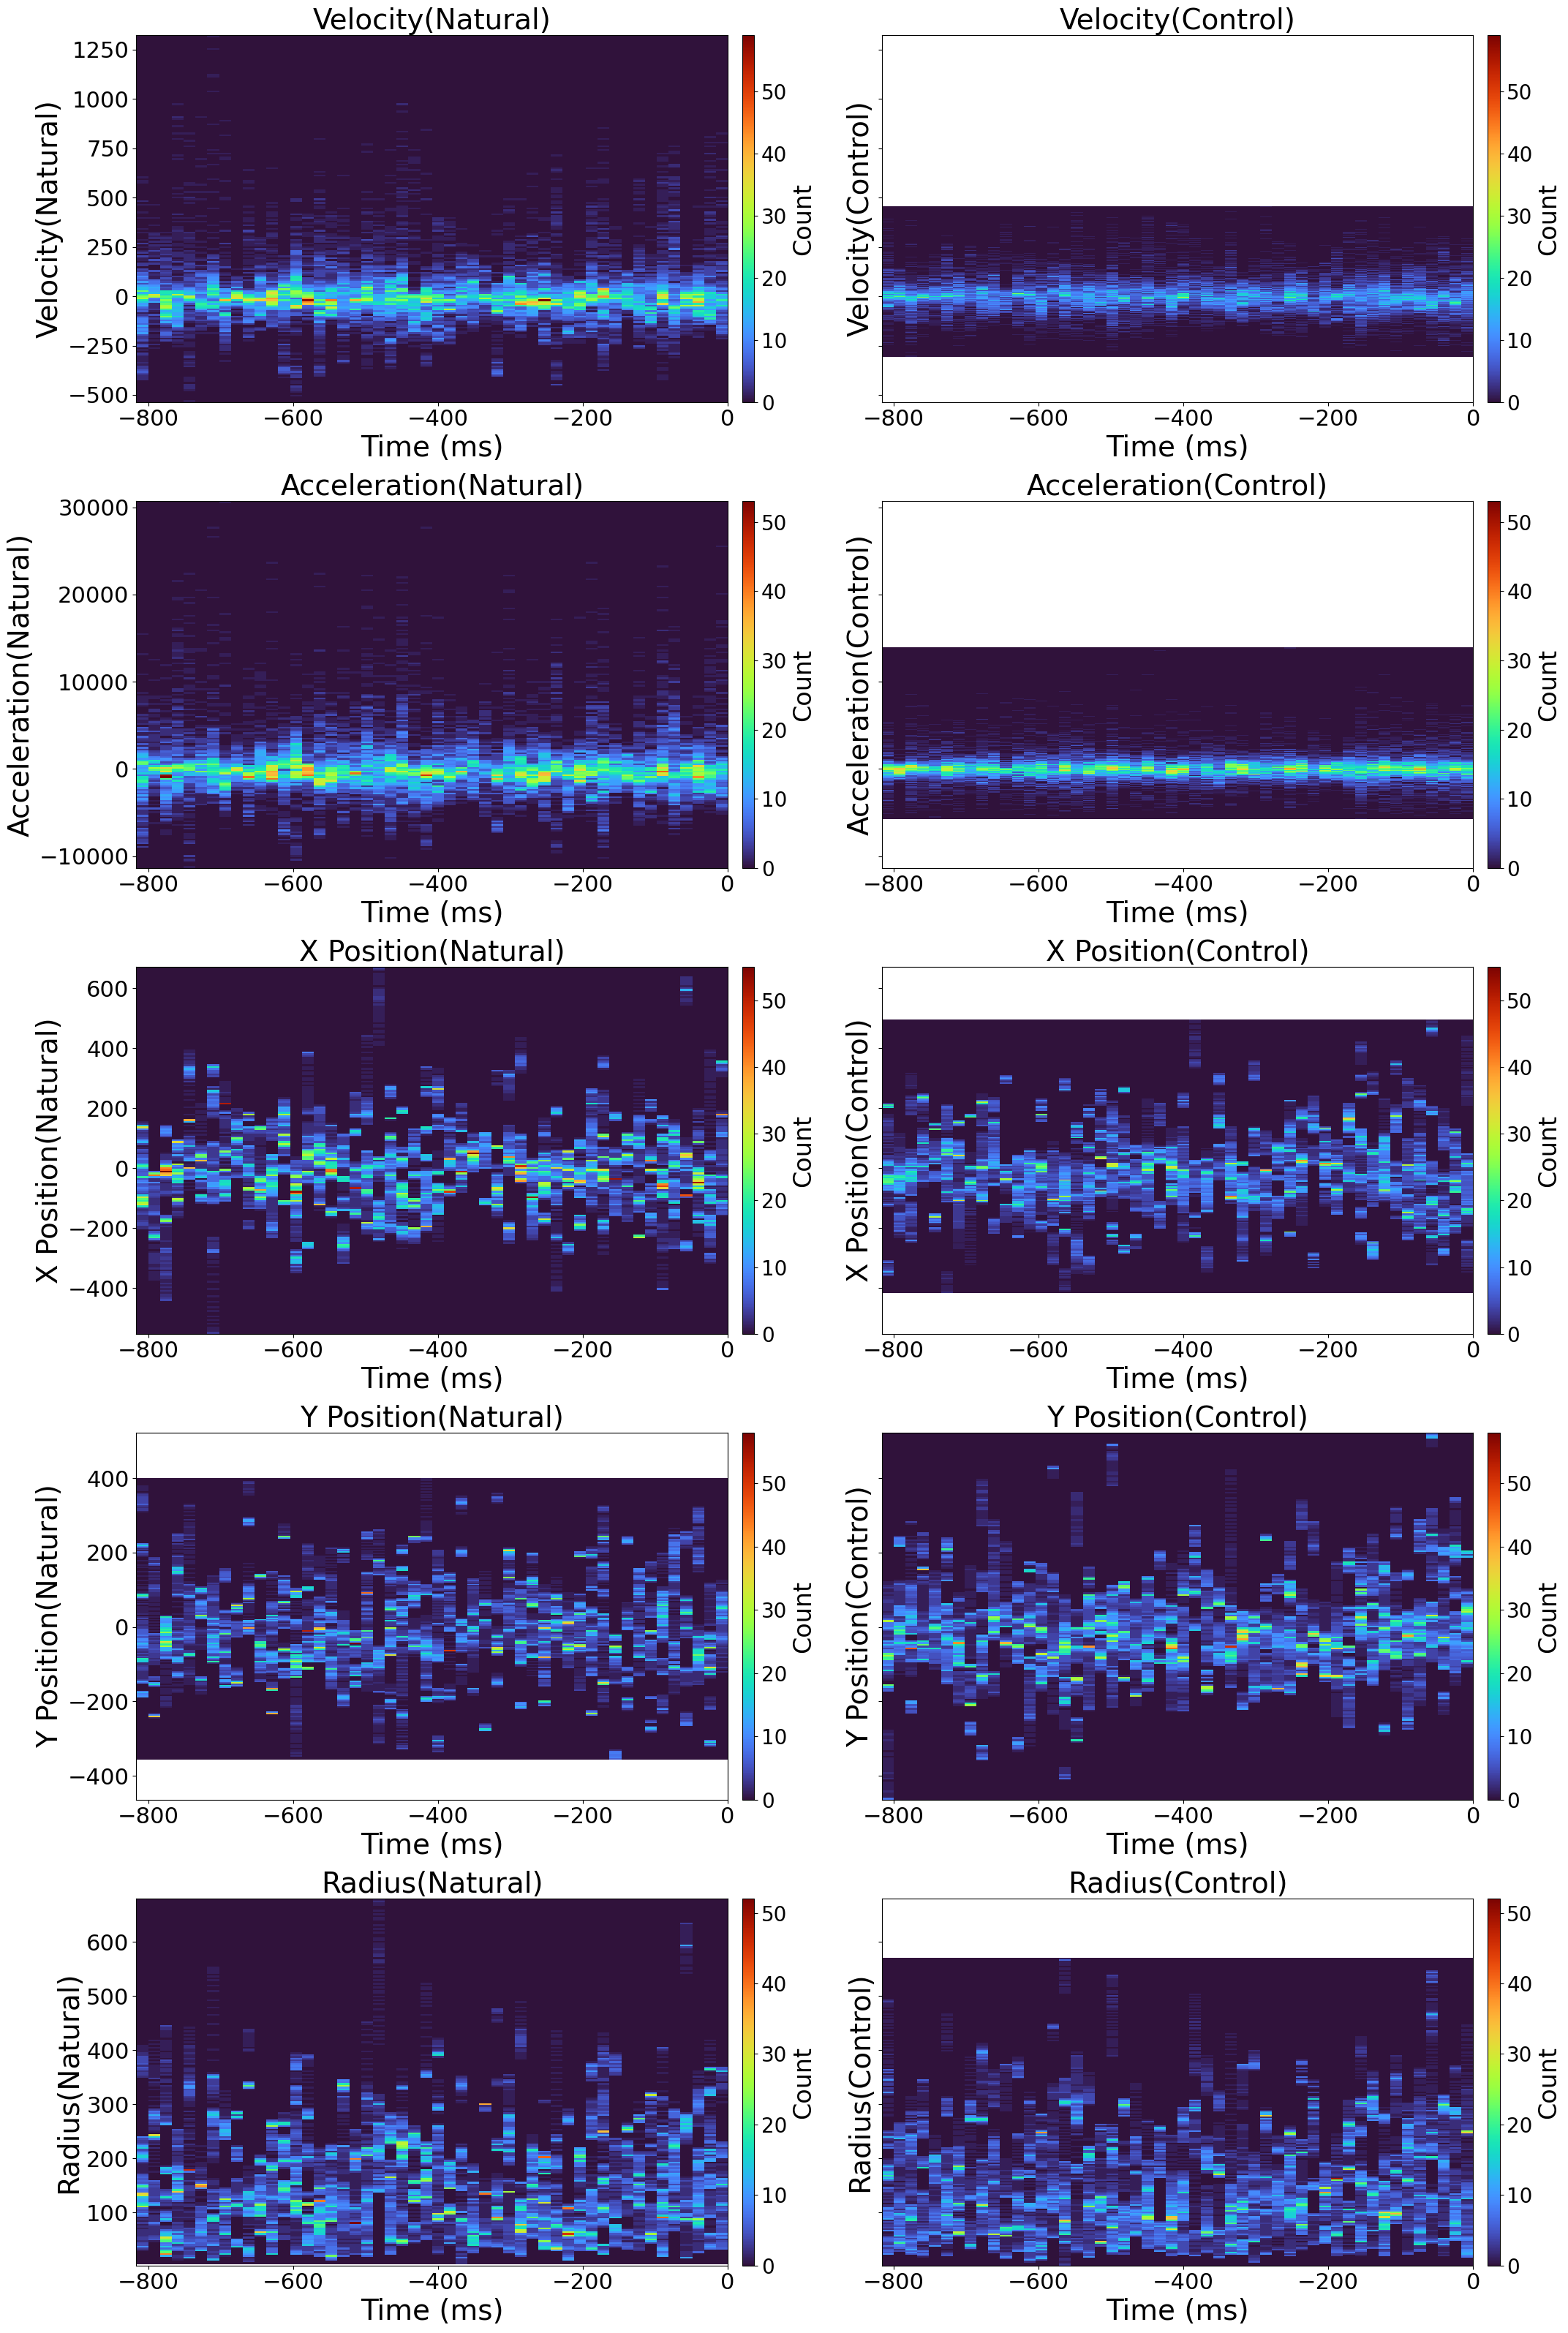

In [14]:

time_points = np.arange(-49,1) 

def plot_heatmap_pcolormesh(ax, data_2d, var_name, time_arr, n_dbins=200, fontsize=28, vmin=None, vmax=None):
    # 1) mask NaNs
    mask = ~np.isnan(data_2d)
    tf = np.tile(time_arr, data_2d.shape[1])[mask.ravel()]
    df = data_2d.ravel()[mask.ravel()]

    # 2) build bin‐edges
    t_edges = np.linspace(time_arr.min(), time_arr.max(), data_2d.shape[0] + 1)
    d_edges = np.linspace(df.min(), df.max(), n_dbins + 1)

    # 3) 2D histogram
    counts, _, _ = np.histogram2d(tf, df, bins=[t_edges, d_edges])

    # 4) mesh it out
    T, D = np.meshgrid(t_edges*100/6, d_edges)
    pcm = ax.pcolormesh(T, D, counts.T,
                        cmap='turbo',
                        shading='auto',
                        vmin=vmin, vmax=vmax)

    ax.set_title(var_name, fontsize=fontsize)
    ax.set_xlabel("Time (ms)", fontsize=fontsize)
    ax.set_ylabel(var_name, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-6)
    # Add colorbar for each subplot
    cbar = plt.colorbar(pcm, ax=ax, pad=0.02, aspect=30)
    cbar.ax.tick_params(labelsize=fontsize-8)
    cbar.set_label('Count', fontsize=fontsize-4)

# Prepare data and names (NO FLASH)
data_list = [avg_sta_v_n, avg_sta_v_c, avg_sta_a_n, avg_sta_a_c, avg_sta_x_n, avg_sta_x_c, avg_sta_y_n, avg_sta_y_c, avg_sta_r_n, avg_sta_r_c]
name_list = [
    "Velocity(Natural)", "Velocity(Control)",
    "Acceleration(Natural)", "Acceleration(Control)",
    "X Position(Natural)", "X Position(Control)",
    "Y Position(Natural)", "Y Position(Control)",
    "Radius(Natural)", "Radius(Control)"
]

# Compute vmin/vmax for each "natural" variable and use for corresponding "control"
# Indices: 0,2,4,6,8 are "natural"; 1,3,5,7,9 are "control"
natural_indices = [0, 2, 4, 6, 8]
control_indices = [1, 3, 5, 7, 9]

vmin_list = [None] * len(data_list)
vmax_list = [None] * len(data_list)

for n_idx, c_idx in zip(natural_indices, control_indices):
    # Compute vmin/vmax for natural
    data_n = data_list[n_idx]
    mask_n = ~np.isnan(data_n)
    tf_n = np.tile(time_points, data_n.shape[1])[mask_n.ravel()]
    df_n = data_n.ravel()[mask_n.ravel()]
    t_edges = np.linspace(time_points.min(), time_points.max(), data_n.shape[0] + 1)
    d_edges = np.linspace(df_n.min(), df_n.max(), 201)
    counts_n, _, _ = np.histogram2d(tf_n, df_n, bins=[t_edges, d_edges])
    vmin = counts_n.min()
    vmax = counts_n.max()
    vmin_list[n_idx] = vmin
    vmax_list[n_idx] = vmax
    # Use same vmin/vmax for control
    vmin_list[c_idx] = vmin
    vmax_list[c_idx] = vmax

fig, axes = plt.subplots(5, 2,
                         figsize=(22, 32),
                         sharey='row')
for i, (ax, data, label) in enumerate(zip(axes.flat, data_list, name_list)):
    plot_heatmap_pcolormesh(ax, data, label, time_points, fontsize=28, vmin=vmin_list[i], vmax=vmax_list[i])
plt.tight_layout()
plt.show()

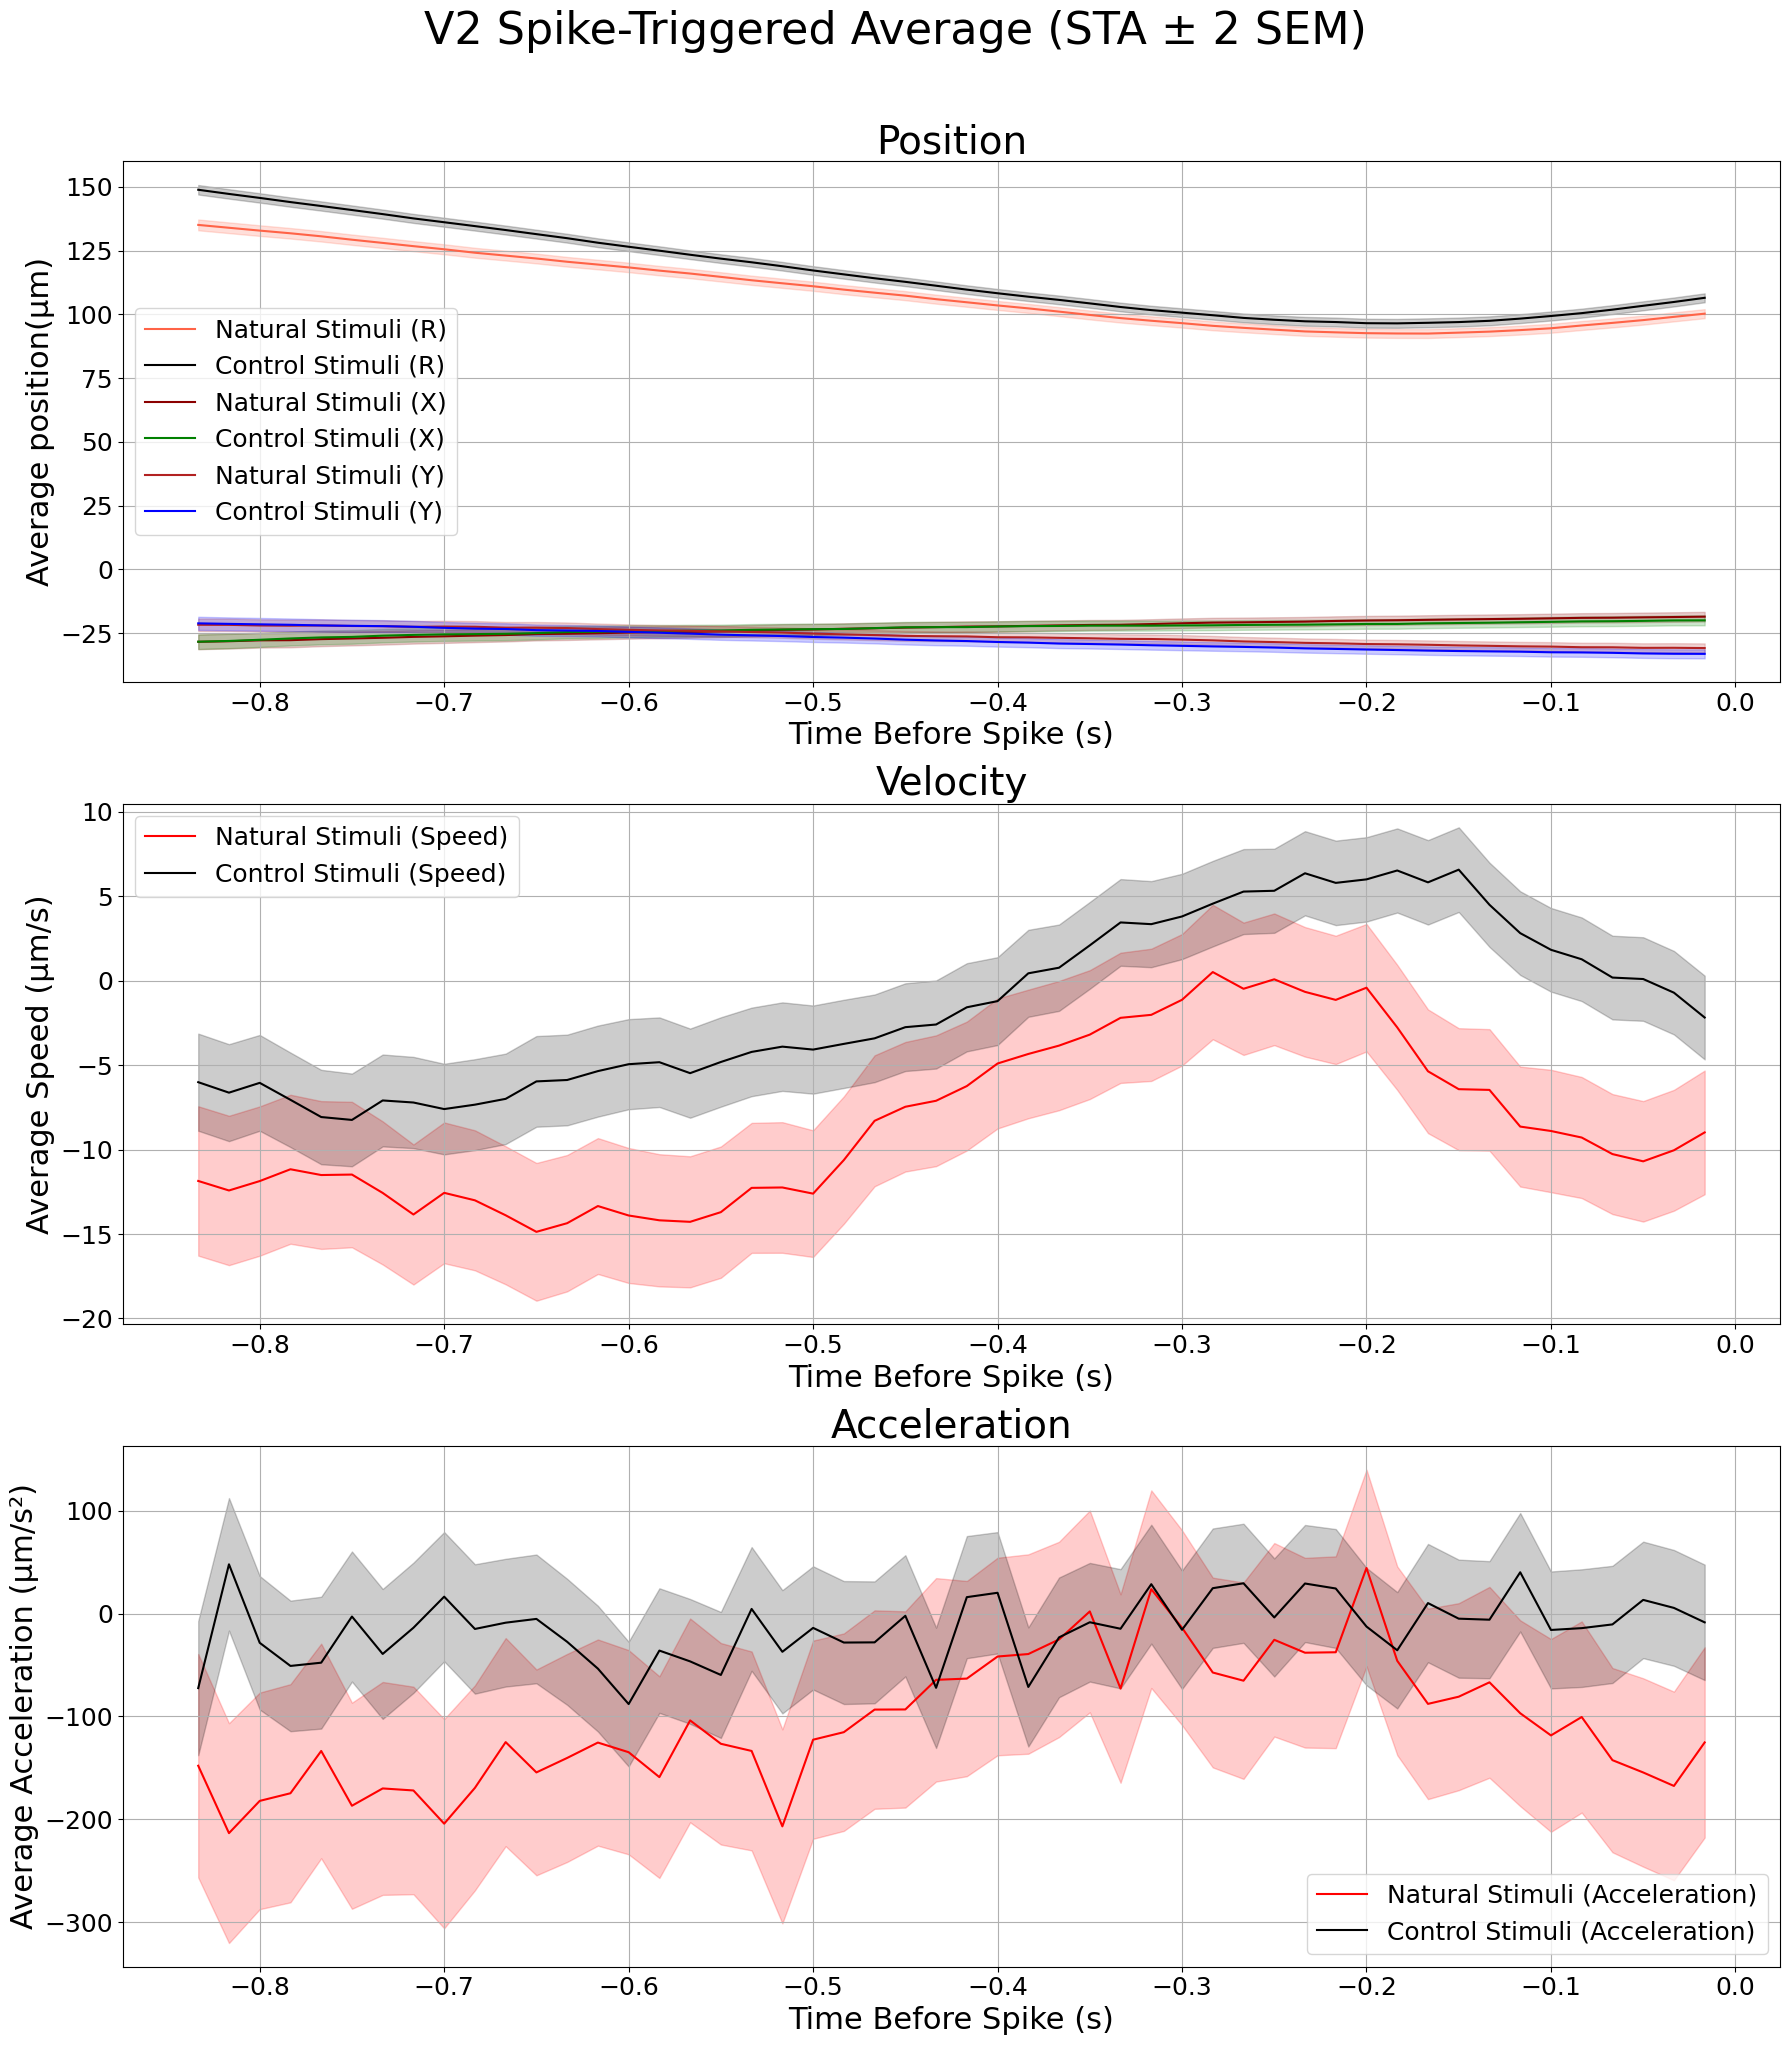

In [15]:
avg_sta_v_n = np.nanmean(sta_v_n, axis=(1,2))
avg_sta_a_n = np.nanmean(sta_a_n, axis=(1,2))
avg_sta_x_n = np.nanmean(sta_x_n, axis=(1,2))
avg_sta_y_n = np.nanmean(sta_y_n, axis=(1,2))
avg_sta_r_n = np.nanmean(sta_r_n, axis=(1,2))

avg_sta_v_c = np.nanmean(sta_v_c, axis=(1,2))
avg_sta_a_c = np.nanmean(sta_a_c, axis=(1,2))
avg_sta_x_c = np.nanmean(sta_x_c, axis=(1,2))
avg_sta_y_c = np.nanmean(sta_y_c, axis=(1,2))
avg_sta_r_c = np.nanmean(sta_r_c, axis=(1,2))
# Plot STA for velocity and acceleration
time_window = np.linspace(-T * dt, -dt, T)

sem_x_n = np.nanstd(sta_x_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_x_c = np.nanstd(sta_x_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))
sem_y_n = np.nanstd(sta_y_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_y_c = np.nanstd(sta_y_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))
sem_r_n = np.nanstd(sta_r_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_r_c = np.nanstd(sta_r_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))


sem_v_n = np.nanstd(sta_v_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_v_c = np.nanstd(sta_v_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))

sem_a_n = np.nanstd(sta_a_n.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_n, axis=(1,2)))
sem_a_c = np.nanstd(sta_a_c.reshape(T, -1), axis=1) / np.sqrt(np.nansum(d_c, axis=(1,2)))

# Set font sizes
title_fontsize = 28
label_fontsize = 22
tick_fontsize = 18
legend_fontsize = 18
plt.figure(figsize=(18, 20))
plt.suptitle('V2 Spike-Triggered Average (STA ± 2 SEM)', fontsize=title_fontsize + 4, y=1.02)

# Position
plt.subplot(3, 1, 1)
plt.plot(time_window, avg_sta_r_n, label='Natural Stimuli (R)', color='tomato')
plt.fill_between(time_window,  avg_sta_r_n - 2 * sem_r_n,  avg_sta_r_n + 2 * sem_r_n,color='tomato', alpha=0.2)
plt.plot(time_window, avg_sta_r_c, label='Control Stimuli (R)', color='k')
plt.fill_between(time_window,  avg_sta_r_c - 2 * sem_r_c,  avg_sta_r_c + 2 * sem_r_c,color='k', alpha=0.2)
# plt.plot(time_window, avg_sta_r_f, label='Flash Stimuli (R)', color='yellow')
# plt.fill_between(time_window,  avg_sta_r_f - 2 * sem_r_f,  avg_sta_r_f + 2 * sem_r_f,color='yellow', alpha=0.2)
plt.plot(time_window, avg_sta_x_n, label='Natural Stimuli (X)', color='darkred')
plt.fill_between(time_window,  avg_sta_x_n - 2 * sem_x_n,  avg_sta_x_n + 2 * sem_x_n,color='darkred', alpha=0.2)
plt.plot(time_window, avg_sta_x_c, label='Control Stimuli (X)', color='green')
plt.fill_between(time_window,  avg_sta_x_c - 2 * sem_x_c,  avg_sta_x_c + 2 * sem_x_c,color='green', alpha=0.2)
# plt.plot(time_window, avg_sta_x_f, label='Flash Stimuli (X)', color='yellow')
# plt.fill_between(time_window,  avg_sta_x_f - 2 * sem_x_f,  avg_sta_x_f + 2 * sem_x_f,color='yellow', alpha=0.2)
plt.plot(time_window, avg_sta_y_n, label='Natural Stimuli (Y)', color='firebrick')
plt.fill_between(time_window,  avg_sta_y_n - 2 * sem_y_n,  avg_sta_y_n + 2 * sem_y_n,color='firebrick', alpha=0.2)
plt.plot(time_window, avg_sta_y_c, label='Control Stimuli (Y)', color='blue')
plt.fill_between(time_window,  avg_sta_y_c - 2 * sem_y_c,  avg_sta_y_c + 2 * sem_y_c,color='blue', alpha=0.2)
# plt.plot(time_window, avg_sta_y_f, label='Flash Stimuli (Y)', color='yellow')
# plt.fill_between(time_window,  avg_sta_y_f - 2 * sem_y_f,  avg_sta_y_f + 2 * sem_y_f,color='yellow', alpha=0.2)

plt.xlabel('Time Before Spike (s)', fontsize=label_fontsize)
plt.ylabel('Average position(μm)', fontsize=label_fontsize)
plt.title('Position', fontsize=title_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Velocity
plt.subplot(3, 1, 2)
plt.plot(time_window, avg_sta_v_n, label='Natural Stimuli (Speed)', color='red')
plt.fill_between(time_window,  avg_sta_v_n - 2 * sem_v_n,  avg_sta_v_n + 2 * sem_v_n,color='red', alpha=0.2)
plt.plot(time_window, avg_sta_v_c, label='Control Stimuli (Speed)', color='k')
plt.fill_between(time_window,  avg_sta_v_c - 2 * sem_v_c,  avg_sta_v_c + 2 * sem_v_c,color='k', alpha=0.2)
plt.xlabel('Time Before Spike (s)', fontsize=label_fontsize)
plt.ylabel('Average Speed (μm/s)', fontsize=label_fontsize)
plt.title('Velocity', fontsize=title_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Acceleration
plt.subplot(3, 1, 3)
plt.plot(time_window, avg_sta_a_n, label='Natural Stimuli (Acceleration)', color='red')
plt.fill_between(time_window,  avg_sta_a_n - 2 * sem_a_n, avg_sta_a_n + 2 * sem_a_n,color='red', alpha=0.2)
plt.plot(time_window, avg_sta_a_c, label='Control Stimuli (Acceleration)', color='k')
plt.fill_between(time_window, avg_sta_a_c - 2 * sem_a_c, avg_sta_a_c + 2 * sem_a_c,color='k', alpha=0.2)
plt.xlabel('Time Before Spike (s)', fontsize=label_fontsize)
plt.ylabel('Average Acceleration (μm/s²)', fontsize=label_fontsize)
plt.title('Acceleration', fontsize=title_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()

# LN-GC model

# stimuli generation

In [16]:

# stimuli_c=[]
# for i in range(trajx_c.shape[0]):
#     stimuli_c.append(sg.generate_stimuli(trajx_c[i], trajy_c[i], board_size=900, diameter=30,fps = 60,pretime =0,tailtime =0,type='natural',preframes=30,tailframes=60,stimframes=60))
# stimuli_n=[]
# for i in range(trajx_n.shape[0]):
#     stimuli_n.append(sg.generate_stimuli(trajx_n[i], trajy_n[i], board_size=900, diameter=30,fps = 60,pretime =0,tailtime =0,type='natural',preframes=30,tailframes=60,stimframes=60))


In [17]:
n_cells   = trajx_c.shape[0] 
n_frames  = 151
H = W     = 401
dtype     = 'uint8'

with h5py.File('results/stimuli400_cV2.h5', 'w') as f:
    # 1) movie dataset  (chunk = one full movie for fast per‑cell IO)
    dset = f.create_dataset(
        'stimuli',
        shape      =(n_cells, n_frames, H, W),
        dtype      = 'uint8',
        chunks     =(1, n_frames, H, W),
        compression='gzip',
        shuffle    = True
    )
    # 2) epoch‑ID dataset  (1‑D uint64)
    f.create_dataset(
        'epoch_id',
        data       = np.asarray(epoch_id_c, dtype='uint16')
    )

    # 3) fill the movies, one cell at a time
    for i in range(n_cells):
        movie = sg.generate_stimuli(
            trajx_c[i], trajy_c[i],
            board_size = H-1,
            diameter   = 30,
            fps        = 60,
            pretime    = 0, tailtime = 0,
            type       ='natural',
            preframes  = 30, tailframes = 60, stimframes = 60
        )
        dset[i] = movie            # direct disk write → no RAM spike
        print(f'cell {i:3d} written  epoch_id={epoch_id_c[i]}')

cell   0 written  epoch_id=[[1294.]]
cell   1 written  epoch_id=[[1291.]]
cell   2 written  epoch_id=[[1285.]]
cell   3 written  epoch_id=[[1284.]]
cell   4 written  epoch_id=[[1280.]]
cell   5 written  epoch_id=[[1278.]]
cell   6 written  epoch_id=[[1276.]]
cell   7 written  epoch_id=[[1275.]]
cell   8 written  epoch_id=[[1274.]]
cell   9 written  epoch_id=[[1272.]]
cell  10 written  epoch_id=[[1267.]]
cell  11 written  epoch_id=[[1266.]]
cell  12 written  epoch_id=[[1261.]]
cell  13 written  epoch_id=[[1259.]]
cell  14 written  epoch_id=[[1258.]]
cell  15 written  epoch_id=[[1254.]]
cell  16 written  epoch_id=[[1251.]]
cell  17 written  epoch_id=[[1250.]]
cell  18 written  epoch_id=[[1249.]]
cell  19 written  epoch_id=[[1247.]]
cell  20 written  epoch_id=[[1244.]]
cell  21 written  epoch_id=[[1242.]]
cell  22 written  epoch_id=[[1240.]]
cell  23 written  epoch_id=[[1238.]]
cell  24 written  epoch_id=[[1237.]]
cell  25 written  epoch_id=[[1234.]]
cell  26 written  epoch_id=[[1232.]]
c

In [19]:
with h5py.File('results/stimuli400_nV2.h5', 'w') as f:
    # 1) movie dataset  (chunk = one full movie for fast per‑cell IO)
    dset = f.create_dataset(
        'stimuli',
        shape      =(n_cells, n_frames, H, W),
        dtype      = 'uint8',
        chunks     =(1, n_frames, H, W),
        compression='gzip',
        shuffle    = True
    )
    # 2) epoch‑ID dataset  (1‑D uint64)
    f.create_dataset(
        'epoch_id',
        data       = np.asarray(epoch_id_n, dtype='uint16')
    )

    # 3) fill the movies, one cell at a time
    for i in range(n_cells):
        movie = sg.generate_stimuli(
            trajx_n[i], trajy_n[i],
            board_size = H-1,
            diameter   = 30,
            fps        = 60,
            pretime    = 0, tailtime = 0,
            type       ='natural',
            preframes  = 30, tailframes = 60, stimframes = 60
        )
        dset[i] = movie            # direct disk write → no RAM spike
        print(f'cell {i:3d} written  epoch_id={epoch_id_n[i]}')

cell   0 written  epoch_id=[[1295.]]
cell   1 written  epoch_id=[[1293.]]
cell   2 written  epoch_id=[[1292.]]
cell   3 written  epoch_id=[[1290.]]
cell   4 written  epoch_id=[[1289.]]
cell   5 written  epoch_id=[[1288.]]
cell   6 written  epoch_id=[[1287.]]
cell   7 written  epoch_id=[[1286.]]
cell   8 written  epoch_id=[[1283.]]
cell   9 written  epoch_id=[[1282.]]
cell  10 written  epoch_id=[[1281.]]
cell  11 written  epoch_id=[[1279.]]
cell  12 written  epoch_id=[[1277.]]
cell  13 written  epoch_id=[[1273.]]
cell  14 written  epoch_id=[[1271.]]
cell  15 written  epoch_id=[[1270.]]
cell  16 written  epoch_id=[[1269.]]
cell  17 written  epoch_id=[[1268.]]
cell  18 written  epoch_id=[[1265.]]
cell  19 written  epoch_id=[[1264.]]
cell  20 written  epoch_id=[[1263.]]
cell  21 written  epoch_id=[[1262.]]
cell  22 written  epoch_id=[[1260.]]
cell  23 written  epoch_id=[[1257.]]
cell  24 written  epoch_id=[[1256.]]
cell  25 written  epoch_id=[[1255.]]
cell  26 written  epoch_id=[[1253.]]
c

In [ ]:
# with h5py.File('results/stimuli_cV2.h5', 'r') as f:
#     movies_c     = f['stimuli']      # 4‑D dataset, chunked & compressed
#     epoch_ids_c  = f['epoch_id'][:]  # NumPy array in RAM (tiny)

#     for i in epoch_id_c:
#         idx = np.where(epoch_ids_c == i)[0]
#         if idx.size:
#             var_name = f'movie_c{i}'         # e.g. 'movie1993'
#             globals()[var_name] = movies_c[idx[0]]  # one line reads the whole 3‑D movie


# sg.animate_stimuli(movie1883, [-750,750],  [-750,750], filename="stimuli_c1883.html")


In [ ]:
# with h5py.File('stimuli_nV2.h5', 'r') as f:
#     movies_n     = f['stimuli']      # 4‑D dataset, chunked & compressed
#     epoch_ids_n  = f['epoch_id'][:]  # NumPy array in RAM (tiny)

#     for i in epoch_id_n:
#         idx = np.where(epoch_ids_n == i)[0]
#         if idx.size:
#             var_name = f'movie_n{i}'         # e.g. 'movie1993'
#             globals()[var_name] = movies_n[idx[0]]  # one line reads the whole 3‑D movie